In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mlxtend.plotting import scatterplotmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline 
import tensorflow
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization
from keras.layers.core import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
print(tensorflow.__version__)
print(np.__version__)

2.8.2
1.21.6


In [3]:
%run "./plots.py"
%run "./helper.py"

In [4]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('./startup_data.csv')
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,1/1/2007,NaN,4/1/2009,1/1/2010,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,1/1/2000,NaN,2/14/2005,12/28/2009,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,3/18/2009,NaN,3/30/2010,3/30/2010,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,1/1/2002,NaN,2/17/2005,4/25/2007,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,8/1/2010,10/1/2012,8/1/2010,4/1/2012,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [5]:
print(f'Dataset contains {df.shape[0]} and {df.shape[1]} columns.')

Dataset contains 923 and 49 columns.


## Target variable

In [6]:
if (df['status'].dtype == object):
    df['status'] = df.status.map({'acquired': 1, 'closed': 0})

## Data splitting

In [7]:
features = ['age_first_funding_year', 'age_last_funding_year', 'relationships', 'funding_rounds', 
            'funding_total_usd', 'milestones', 'has_VC', 'has_angel', 'has_roundA', 
            'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'is_top500']

X = df[features]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=1)

In [8]:
standard_scaler = StandardScaler()
X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

X_train_std

array([[-0.79743005, -1.04345191,  0.76233191, ..., -0.32879797,
         1.57245159,  0.50084674],
       [-0.96803128, -1.38406205,  0.18839572, ..., -0.32879797,
        -0.97592536, -1.99661876],
       [-0.80802736, -0.00720624,  0.04491167, ..., -0.32879797,
         0.63357587,  0.50084674],
       ...,
       [-0.67873243, -0.21282209,  1.47975215, ..., -0.32879797,
        -0.43942495,  0.50084674],
       [-0.22734112,  1.78451814,  1.3362681 , ...,  3.04138127,
        -0.61824054,  0.50084674],
       [-0.42018124, -0.01533962,  0.04491167, ..., -0.32879797,
         0.09707546,  0.50084674]])

In [9]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

y_train

array([1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1.

In [156]:
config = {
    'INPUT_SHAPE': (14,),
    'BATCH_SIZE': 256,
    'EPOCHS': 200,
    'OPTIMIZER': 'Adam',
    'LOSS': 'binary_crossentropy',
    'ES_PATIENCE': 20,
    'BEST_MODEL': 'best_model_1.h5'
}

In [275]:
model = Sequential()

model.add(Dense(units=256, input_shape=config['INPUT_SHAPE'], name='h1'))
model.add(LeakyReLU(0.2))
model.add(Dropout(0.5))
model.add(BatchNormalization(momentum=0.8))

model.add(Dense(units=256, name='h2'))
model.add(LeakyReLU(0.2))
model.add(Dropout(0.5))
model.add(BatchNormalization(momentum=0.8))

model.add(Dense(units=1, activation='sigmoid', name='out'))

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 256)               3840      
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_44 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_37 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 h2 (Dense)                  (None, 256)               65792     
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 256)               0         
                                                     

In [276]:
model.compile(loss=config['LOSS'], optimizer=config['OPTIMIZER'], metrics=['Precision'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=config['ES_PATIENCE']) 

mc = ModelCheckpoint(config['BEST_MODEL'], monitor='val_precision', mode='max', verbose=1, save_best_only=True)

In [277]:
history = model.fit(X_train_std, 
                    y_train, 
                    epochs=config['EPOCHS'], 
                    batch_size=config['BATCH_SIZE'], 
                    validation_split=0.2, 
                    callbacks=[es, mc], 
                    workers=12,
                    verbose=1)

Epoch 1/200
1/3 [=========>....................] - ETA: 2s - loss: 0.8417 - precision: 0.6923
Epoch 1: val_precision improved from -inf to 0.75949, saving model to best_model_1.h5
3/3 [==============================] - 2s 170ms/step - loss: 0.8118 - precision: 0.7292 - val_loss: 0.6154 - val_precision: 0.7595
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7259 - precision: 0.8095
Epoch 2: val_precision improved from 0.75949 to 0.81250, saving model to best_model_1.h5
3/3 [==============================] - 0s 37ms/step - loss: 0.7433 - precision: 0.7889 - val_loss: 0.6121 - val_precision: 0.8125
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7118 - precision: 0.8030
Epoch 3: val_precision improved from 0.81250 to 0.81538, saving model to best_model_1.h5
3/3 [==============================] - 0s 38ms/step - loss: 0.6849 - precision: 0.8063 - val_loss: 0.6146 - val_precision: 0.8154
Epoch 4/200
1/3 [=========>....................] - ETA: 0s - lo

## Model evaluation

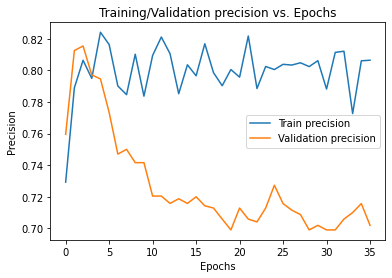

In [278]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Training/Validation precision vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(['Train precision', 'Validation precision'], loc='best')
# plt.savefig('image', bbox_inches='tight')
plt.show()

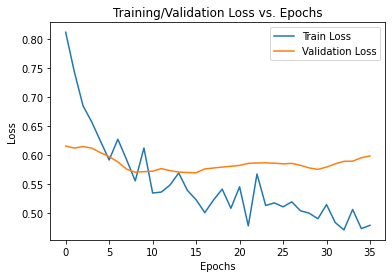

In [279]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training/Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
# plt.savefig('image', bbox_inches='tight')
plt.show()

In [280]:
best_model = load_model(config['BEST_MODEL'])

In [306]:
test_results = best_model.evaluate(X_test_std, y_test, batch_size=config['BATCH_SIZE'], workers=12, return_dict=True)
print(f'Test results:\t Loss: {test_results["loss"]:.4f}\t Precision: {test_results["precision"]:.4f}')

1/1 [==============================] - 0s 24ms/step - loss: 0.5859 - precision: 0.8795
Test results:	 Loss: 0.5859	 Precision: 0.8795


In [282]:
train_probas = best_model.predict(X_train_std, workers=12)
train_probas = train_probas.reshape(-1)
train_y_pred = (train_probas > 0.5).astype(int)
evaluate_classifier(y_train.astype(int), train_y_pred)

Accuracy: 0.6951
Recall: 0.6457
Precision: 0.8462
F1: 0.7325


In [283]:
test_probas = best_model.predict(X_test_std, workers=12)
test_probas = test_probas.reshape(-1)
test_y_pred = (test_probas > 0.5).astype(int)
evaluate_classifier(y_test.astype(int), test_y_pred)

Accuracy: 0.6919
Recall: 0.6083
Precision: 0.8795
F1: 0.7192


In [284]:
confusion_matrix = metrics.confusion_matrix(y_true=y_test.astype(int), y_pred=test_y_pred)
confusion_matrix

array([[55, 10],
       [47, 73]])

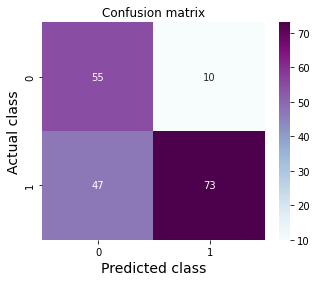

In [285]:
plot_confusion_matrix(confusion_matrix=confusion_matrix, figsize=(5, 4))

## Comparing false positives with true positives

In [286]:
y_test_arr = y_test.astype(int)
false_positives = (y_test_arr != test_y_pred) & (y_test_arr == 0)
df_false_positives = X_test[false_positives]
print(f'False positives count: {len(df_false_positives)}')
df_false_positives

False positives count: 10


,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
439,2.4438,7.1973,6,3,25500100,3,1,0,0,1,0,0,2.50,1
345,1.1836,1.3781,7,2,1900000,2,0,1,1,0,0,0,2.50,1
36,0.6192,1.5945,8,2,14600000,3,0,0,1,1,0,0,2.00,1
105,2.4658,4.8329,4,2,5000000,6,0,0,1,1,0,0,1.00,0
202,0.8164,5.5616,8,4,32500000,3,0,0,1,1,1,1,2.75,1
584,-3.5068,0.3945,5,3,11300000,2,1,0,0,1,1,0,1.00,1
515,2.1616,3.2877,13,2,33000000,4,0,0,1,1,0,0,2.50,1
206,1.1699,1.4986,3,2,4700000,4,0,1,1,0,0,0,1.50,1
707,3.0356,6.7534,2,3,33000000,1,0,0,1,1,1,0,4.00,1
230,2.1890,2.1890,32,1,9000000,0,0,0,0,1,0,0,4.00,1


In [287]:
true_positives = (y_test_arr == test_y_pred) & (y_test_arr == 1)
df_true_positives = X_test[true_positives]
print(f'True positives count: {len(df_true_positives)}')
df_true_positives

True positives count: 73


,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
621,5.6438,5.6438,9,1,12700000,2,0,0,0,0,0,1,4.0000,1
156,4.7068,4.7068,17,1,940261,2,0,0,1,0,0,0,1.0000,1
324,0.4548,0.7041,5,2,1000000,3,1,0,1,0,0,0,5.5000,1
145,1.6712,3.7863,11,3,11040000,2,0,0,1,1,1,0,2.5000,1
370,2.2521,4.7397,22,3,39007789,5,0,0,1,1,1,0,3.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,3.1041,4.9205,10,2,11500000,5,0,0,1,1,0,0,2.5000,1
509,0.0411,3.1425,30,2,6875000,5,1,0,1,0,0,0,7.0000,1
261,7.3534,8.1260,13,2,24500000,2,0,0,0,0,0,0,5.5000,1
699,1.1616,4.1644,19,4,33000000,4,0,0,1,1,1,1,1.3333,1


In [288]:
df_false_positives = df_false_positives.assign(prediction=np.full(len(df_false_positives), 1))
df_false_positives = df_false_positives.assign(ground_truth=np.full(len(df_false_positives), 0))

df_true_positives = df_true_positives.assign(prediction=np.full(len(df_true_positives), 1))
df_true_positives = df_true_positives.assign(ground_truth=np.full(len(df_true_positives), 1))

df_predictions = pd.concat([df_false_positives, df_true_positives])
df_predictions

,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,prediction,ground_truth
439,2.4438,7.1973,6,3,25500100,3,1,0,0,1,0,0,2.5000,1,1,0
345,1.1836,1.3781,7,2,1900000,2,0,1,1,0,0,0,2.5000,1,1,0
36,0.6192,1.5945,8,2,14600000,3,0,0,1,1,0,0,2.0000,1,1,0
105,2.4658,4.8329,4,2,5000000,6,0,0,1,1,0,0,1.0000,0,1,0
202,0.8164,5.5616,8,4,32500000,3,0,0,1,1,1,1,2.7500,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,3.1041,4.9205,10,2,11500000,5,0,0,1,1,0,0,2.5000,1,1,1
509,0.0411,3.1425,30,2,6875000,5,1,0,1,0,0,0,7.0000,1,1,1
261,7.3534,8.1260,13,2,24500000,2,0,0,0,0,0,0,5.5000,1,1,1
699,1.1616,4.1644,19,4,33000000,4,0,0,1,1,1,1,1.3333,1,1,1


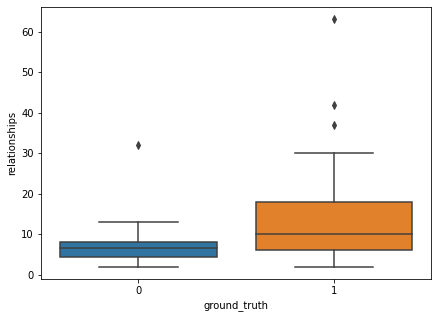

In [289]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='relationships', data=df_predictions)

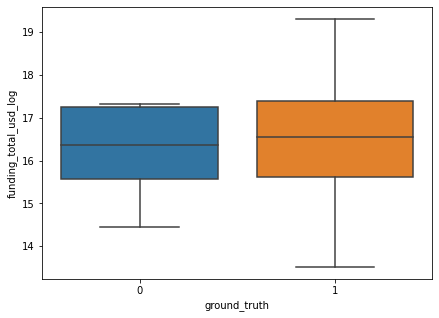

In [290]:
df_predictions['funding_total_usd_log'] = np.log(df_predictions['funding_total_usd'])
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='funding_total_usd_log', data=df_predictions)

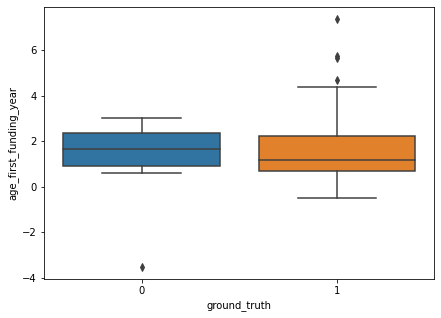

In [291]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='age_first_funding_year', data=df_predictions)

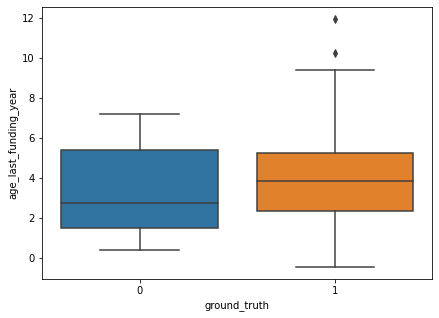

In [292]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='age_last_funding_year', data=df_predictions)

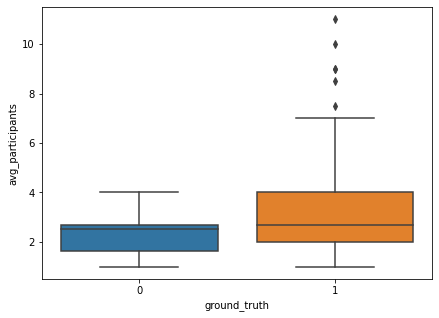

In [293]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='avg_participants', data=df_predictions)

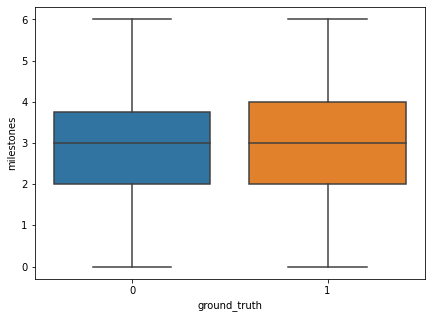

In [294]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='milestones', data=df_predictions)

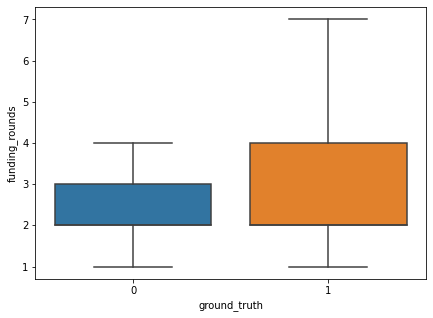

In [295]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='funding_rounds', data=df_predictions)

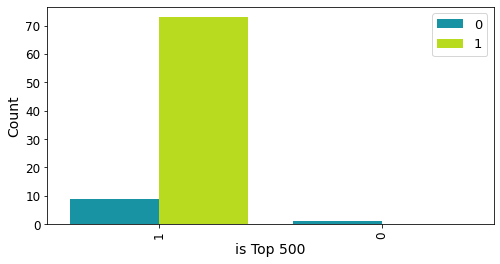

In [296]:
plot_countplot(df=df_predictions, x='is_top500', hue='ground_truth', x_label='is Top 500', y_label='Count',  
                 figsize=(8, 4), sort_by_count=True)

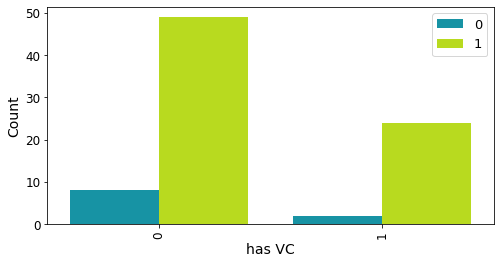

In [297]:
plot_countplot(df=df_predictions, x='has_VC', hue='ground_truth', x_label='has VC', y_label='Count',  
                 figsize=(8, 4), sort_by_count=True)

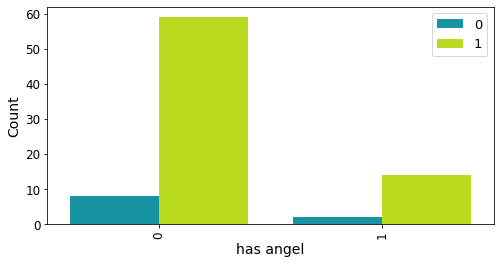

In [298]:
plot_countplot(df=df_predictions, x='has_angel', hue='ground_truth', x_label='has angel', y_label='Count',  
                 figsize=(8, 4), sort_by_count=True)

## Precision/recall tradeoff

In [299]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, test_probas)

In [300]:
threshold_precision = thresholds[np.argmax(precision >= 0.9)]
threshold_precision

0.5318812

In [301]:
test_y_pred_2 = (test_probas >= threshold_precision).astype(int)
evaluate_classifier(y_test.astype(int), test_y_pred_2)

Accuracy: 0.6757
Recall: 0.5583
Precision: 0.9054
F1: 0.6907


In [302]:
confusion_matrix = metrics.confusion_matrix(y_true=y_test.astype(int), y_pred=test_y_pred_2)
confusion_matrix

array([[58,  7],
       [53, 67]])

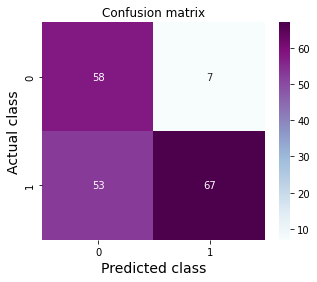

In [303]:
plot_confusion_matrix(confusion_matrix=confusion_matrix, figsize=(5, 4))

In [304]:
y_test_arr = y_test.astype(int)
false_positives = (y_test_arr != test_y_pred_2) & (y_test_arr == 0)
df_false_positives = X_test[false_positives]
print(f'False positives count: {len(df_false_positives)}')
df_false_positives

False positives count: 7


,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
439,2.4438,7.1973,6,3,25500100,3,1,0,0,1,0,0,2.50,1
36,0.6192,1.5945,8,2,14600000,3,0,0,1,1,0,0,2.00,1
105,2.4658,4.8329,4,2,5000000,6,0,0,1,1,0,0,1.00,0
202,0.8164,5.5616,8,4,32500000,3,0,0,1,1,1,1,2.75,1
515,2.1616,3.2877,13,2,33000000,4,0,0,1,1,0,0,2.50,1
206,1.1699,1.4986,3,2,4700000,4,0,1,1,0,0,0,1.50,1
230,2.1890,2.1890,32,1,9000000,0,0,0,0,1,0,0,4.00,1
